In [15]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
import random
import pandas as pd
import itertools
from sklearn.metrics import confusion_matrix
import numpy as np
from tensorflow.keras.utils import plot_model
import os


os.environ["PATH"] += 'C:\Program Files\Graphviz\bin'


# Extract dataset
(train_data, train_labels), (test_data, test_labels) = fashion_mnist.load_data()

class_names = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}


# Create custom min-max scaler
def min_max_scaler(train_data, test_data, new_min=0, new_max=0, scale=0, bias=0):
    min_value = 0 if new_min == new_max else min([train_data.min(), test_data.min()]) 
    max_value = 0 if new_max == new_min else max([train_data.max(), test_data.max()])
    scale = (new_max - new_min) / (max_value - min_value) if scale == 0 else scale
    bias = new_min if bias == 0 else bias
    scaled_dataset = (train_data - min_value) * scale + bias, (test_data - min_value) * scale + bias
    return scaled_dataset

def get_scale(train_data, test_data, new_min, new_max):
    min_value = min([train_data.min(), test_data.min()])
    max_value = max([train_data.max(), test_data.max()])
    scale = (new_max - new_min) / (max_value - min_value)
    bias = new_min
    return scale, bias
    
    
def plot_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    n_classes = cm.shape[0]
    
    fig, ax = plt.subplots(figsize=figsize)
    
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
        
        
    ax.set(title="Confusion matrix",
           xlabel="Predicted label",
           ylabel="True label",
           xticks=np.arange(n_classes),
           yticks=np.arange(n_classes),
           xticklabels=labels,
           yticklabels=labels)
    
    
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    
    
    ax.xaxis.label.set_size(text_size)
    ax.yaxis.label.set_size(text_size)
    ax.title.set_size(text_size)
    
    
    threshold = (cm.max() + cm.min()) / 2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 size=text_size)

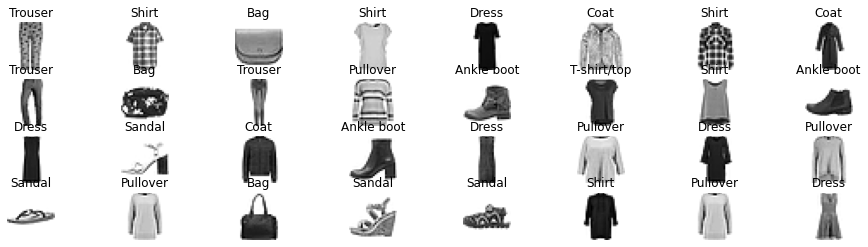

In [2]:
plt.figure(figsize=(16, 4))
for _ in range(8*4):
    ax = plt.subplot(4, 8, _+1)
    choice = random.choice(range(len(train_data)))
    plt.imshow(train_data[choice], cmap=plt.cm.binary)
    plt.title(class_names[train_labels[choice]])
    plt.axis(False)

In [3]:
# Scale data to use it with ELU activation
scale, bias = get_scale(train_data, test_data, -1, 5)
train_data, test_data = min_max_scaler(train_data, test_data, scale=scale, bias=bias)

* Input shape = train_data.shape = image resulution X number of color channels
* Output shape = len(class_names)
* Loss function = tf.keras.losses.CategoricalCrossentropy for one-hot encoded labels or SparseCategoricalCrossentropy for integer labels
* Output layer activation = Softmax

In [4]:
tf.random.set_seed(42)
# elu = tf.keras.activations.elu

model_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(40, activation="elu"),
    tf.keras.layers.Dense(40, activation="sigmoid"),
    tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)
])

model_1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               metrics=["accuracy"])

history_1 = model_1.fit(train_data,
                        train_labels,
                        epochs=15,
                        batch_size=200,
                        validation_data=(test_data, test_labels))


Epoch 1/15
300/300 [==============================] - 1s 2ms/step - loss: 0.7775 - accuracy: 0.7837 - val_loss: 0.5142 - val_accuracy: 0.8313
Epoch 2/15
300/300 [==============================] - 0s 1ms/step - loss: 0.4398 - accuracy: 0.8527 - val_loss: 0.4358 - val_accuracy: 0.8499
Epoch 3/15
300/300 [==============================] - 0s 1ms/step - loss: 0.3823 - accuracy: 0.8671 - val_loss: 0.4074 - val_accuracy: 0.8563
Epoch 4/15
300/300 [==============================] - 0s 1ms/step - loss: 0.3542 - accuracy: 0.8750 - val_loss: 0.3868 - val_accuracy: 0.8633
Epoch 5/15
300/300 [==============================] - 0s 1ms/step - loss: 0.3334 - accuracy: 0.8824 - val_loss: 0.3752 - val_accuracy: 0.8658
Epoch 6/15
300/300 [==============================] - 0s 1ms/step - loss: 0.3187 - accuracy: 0.8855 - val_loss: 0.3691 - val_accuracy: 0.8685
Epoch 7/15
300/300 [==============================] - 0s 1ms/step - loss: 0.3047 - accuracy: 0.8900 - val_loss: 0.3582 - val_accuracy: 0.8754
Epoch 

<AxesSubplot:>

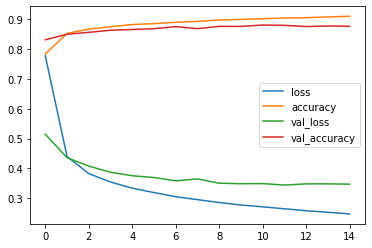

In [5]:
pd.DataFrame(history_1.history).plot()

tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(40, activation="elu"),
    tf.keras.layers.Dense(40, activation="sigmoid"),
    tf.keras.layers.Dense(10, activation="softmax")
])


model_2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch/20))


find_lr_history = model_2.fit(train_data, train_labels,
                            epochs=40,
                            batch_size=200,
                            validation_data=(test_data, test_labels),
                            callbacks=[lr_scheduler]
                           )

lrs = 1e-3 * (10 ** (tf.range(40) / 20))
plt.semilogx(lrs, find_lr_history.history["loss"])
plt.xlabel("Learning rate")
plt.ylabel("Loss")

In [6]:
y_probs = model_1.predict(test_data)

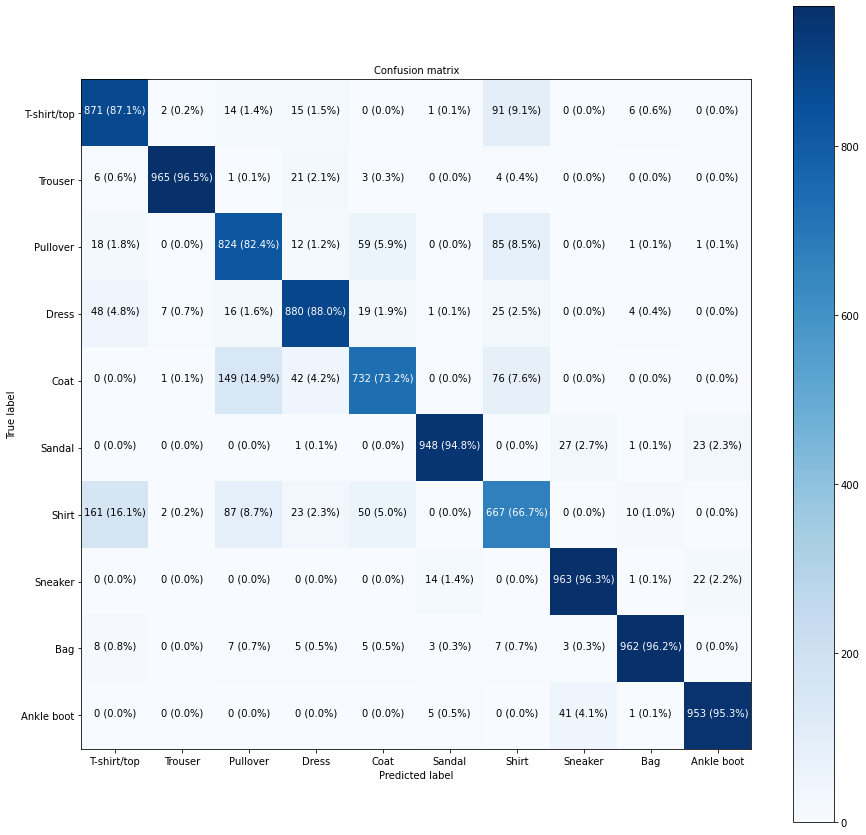

In [7]:
y_pred = y_probs.argmax(axis=1)
plot_confusion_matrix(y_true=test_labels, y_pred=y_pred, classes=class_names.values(), figsize=(15, 15), text_size=10)

In [8]:
# Get 1st layer's weights
weights, biases = model_1.layers[1].get_weights()
weights, weights.shape

(array([[ 0.02556441, -0.03580723, -0.01059566, ..., -0.0113689 ,
         -0.05530085,  0.10565215],
        [-0.04647735,  0.02235439,  0.09383761, ..., -0.10859787,
         -0.00023917,  0.15363453],
        [-0.0627448 , -0.05602138,  0.09539352, ..., -0.05808142,
         -0.03687095,  0.05939908],
        ...,
        [ 0.01664815, -0.04429567, -0.03572381, ...,  0.00558577,
         -0.07940833,  0.14772491],
        [ 0.06065999, -0.04095081,  0.02498202, ..., -0.01157607,
         -0.13849777,  0.14337261],
        [-0.0005023 ,  0.01750208, -0.03147982, ..., -0.04149728,
         -0.06123853,  0.06894834]], dtype=float32),
 (784, 40))

In [9]:
# Bias and biases shapes
biases, biases.shape

(array([ 0.00171396,  0.02581858, -0.01481553, -0.00333877,  0.00637728,
        -0.04529585, -0.04661268,  0.00452799, -0.03799438, -0.07795148,
        -0.01630521, -0.06860369,  0.01616267, -0.03301667,  0.00619533,
         0.02360997, -0.00141053, -0.10862666, -0.01191761, -0.03042472,
         0.02769877,  0.02202668, -0.03006635,  0.048562  ,  0.02875019,
         0.05024679, -0.06359925, -0.0812168 ,  0.0317433 , -0.03874088,
        -0.04234832,  0.00353886,  0.09024945,  0.04829512, -0.05049987,
        -0.06728622, -0.06878434,  0.07580522,  0.02234911, -0.0740427 ],
       dtype=float32),
 (40,))

Every neuron has a bias vector. Each of these is paired with a weights matrix.
The bias vector get initialized as zeros (at least in case of tensorflow dense layer).
The bias vector dictates how much the patterns within the corresponding weights matrix should influence the next layer.

In [16]:
plot_model(model_1, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
